In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, KFold, GroupKFold, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bigcon/bigcon_train_origin.csv", encoding='utf-8', index_col = 0)

In [3]:
log_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bigcon/log_data.csv")

In [ ]:
# # 설치 후 런타임 재실행
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

## 범주형 변수들을 제외한 상관관계

In [ ]:
train_copy = train.copy()
train_copy.drop(['bank_id', 'product_id', 'user_id', 'application_id', 'personal_rehabilitation_yn', 'personal_rehabilitation_complete_yn', ], axis = 1, inplace = True)

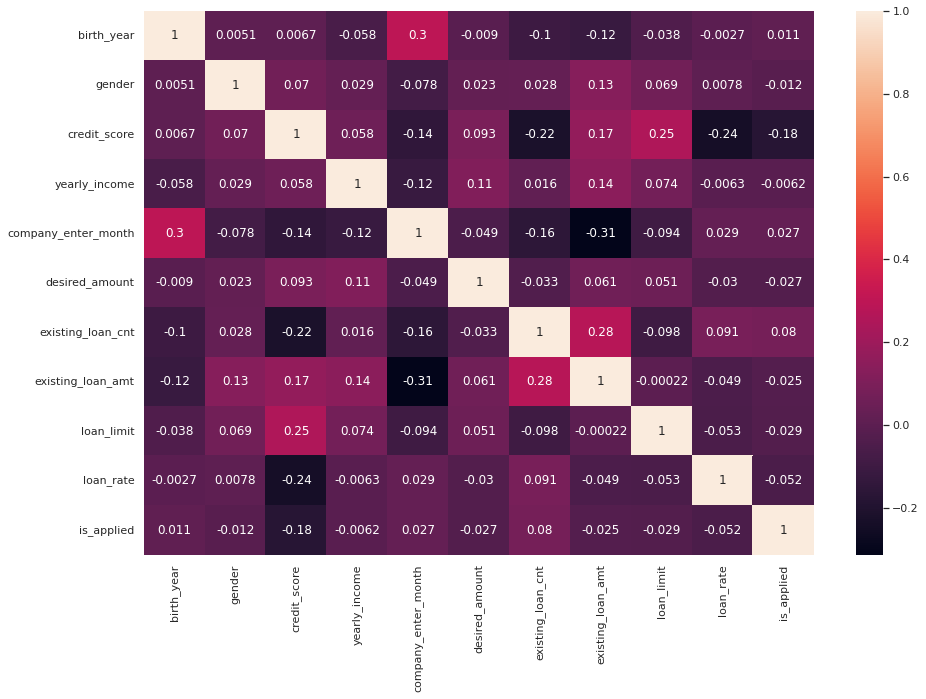

In [ ]:
sns.set(font_scale=1)
plt.figure(figsize=(15,10))
sns.heatmap(train_copy.corr(),annot=True)
plt.show()

## event 칼럼들 생성

log_data의 event칼럼의 행동명들을 횟수로 세서 칼럼으로 바꿔줌.

In [ ]:
df = log_data[['user_id','event']].value_counts().to_frame()

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df.rename(columns = {0: 'count'}, inplace=True)

In [ ]:
event = ['SignUp','OpenApp','Login','ViewLoanApplyIntro','StartLoanApply','CompleteIDCertification',
         'EndLoanApply','UseLoanManage','UsePrepayCalc','UseDSRCalc','GetCreditInfo']

for i in event:
    df_new = df[df['event']==i]
    df_new.drop(['event'], axis= 1, inplace=True)
    train = pd.merge(train,df_new, how = 'outer') 
    train.rename(columns = {"count": i}, inplace = True)

application_id가 결측치가 생긴 이유 : log_data에는 있지만 user_spec과 loan_result를 합친 train 데이터프레임에는 없기 때문에 생김.  
따라서 application_id가 결측치인 행을 삭제

In [ ]:
train.dropna(axis=0, subset=['application_id'], inplace= True)

log_data에서 user_id당 모든 event가 있던 것은 아니므로 새로 만들어준 event칼럼들에 결측치가 있을 것으로 예상하여 확인 후 0으로 채움

In [ ]:
for i in event:
    train[i].fillna(0, inplace=True)

## event 칼럼끼리의 상관관계

In [ ]:
train.copy2 = train.copy()

In [ ]:
train.copy2 = train.copy2[['SignUp', 'OpenApp','Login','ViewLoanApplyIntro','StartLoanApply','CompleteIDCertification','EndLoanApply','UseLoanManage','UsePrepayCalc','UseDSRCalc','GetCreditInfo']]

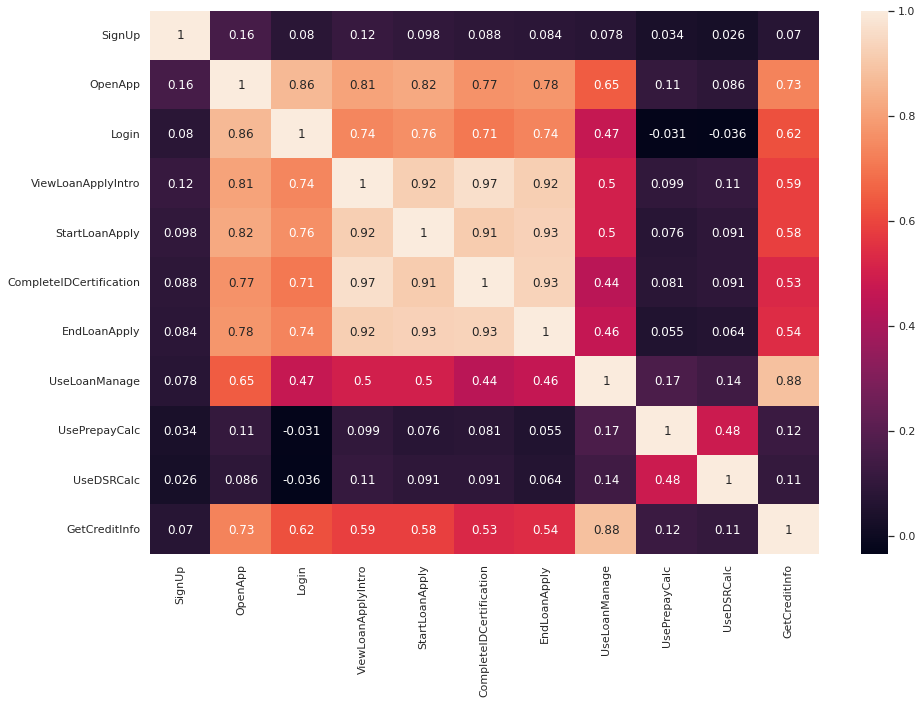

In [ ]:
sns.set(font_scale=1)
plt.figure(figsize=(15,10))
sns.heatmap(train.copy2.corr(),annot=True)
plt.show()

## target 데이터 시각화

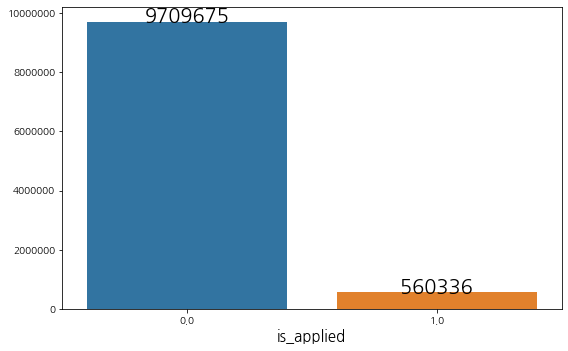

In [ ]:
plt.figure(figsize=(8, 5))
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
target = sns.countplot(x='is_applied', data=train)
target.set(ylabel=None)
target.set_xlabel("is_applied", fontsize = 15)
target.set_ylabel("", fontsize = 15)
for p in target.patches:
    height = p.get_height()
    target.text(p.get_x() + p.get_width() / 2., height + 5, height, ha = 'center', size = 20)

plt.tight_layout()
plt.show()

## 범주형 데이터 시각화 - 총 9개 칼럼

In [4]:
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams['font.family'] = 'NanumGothic'

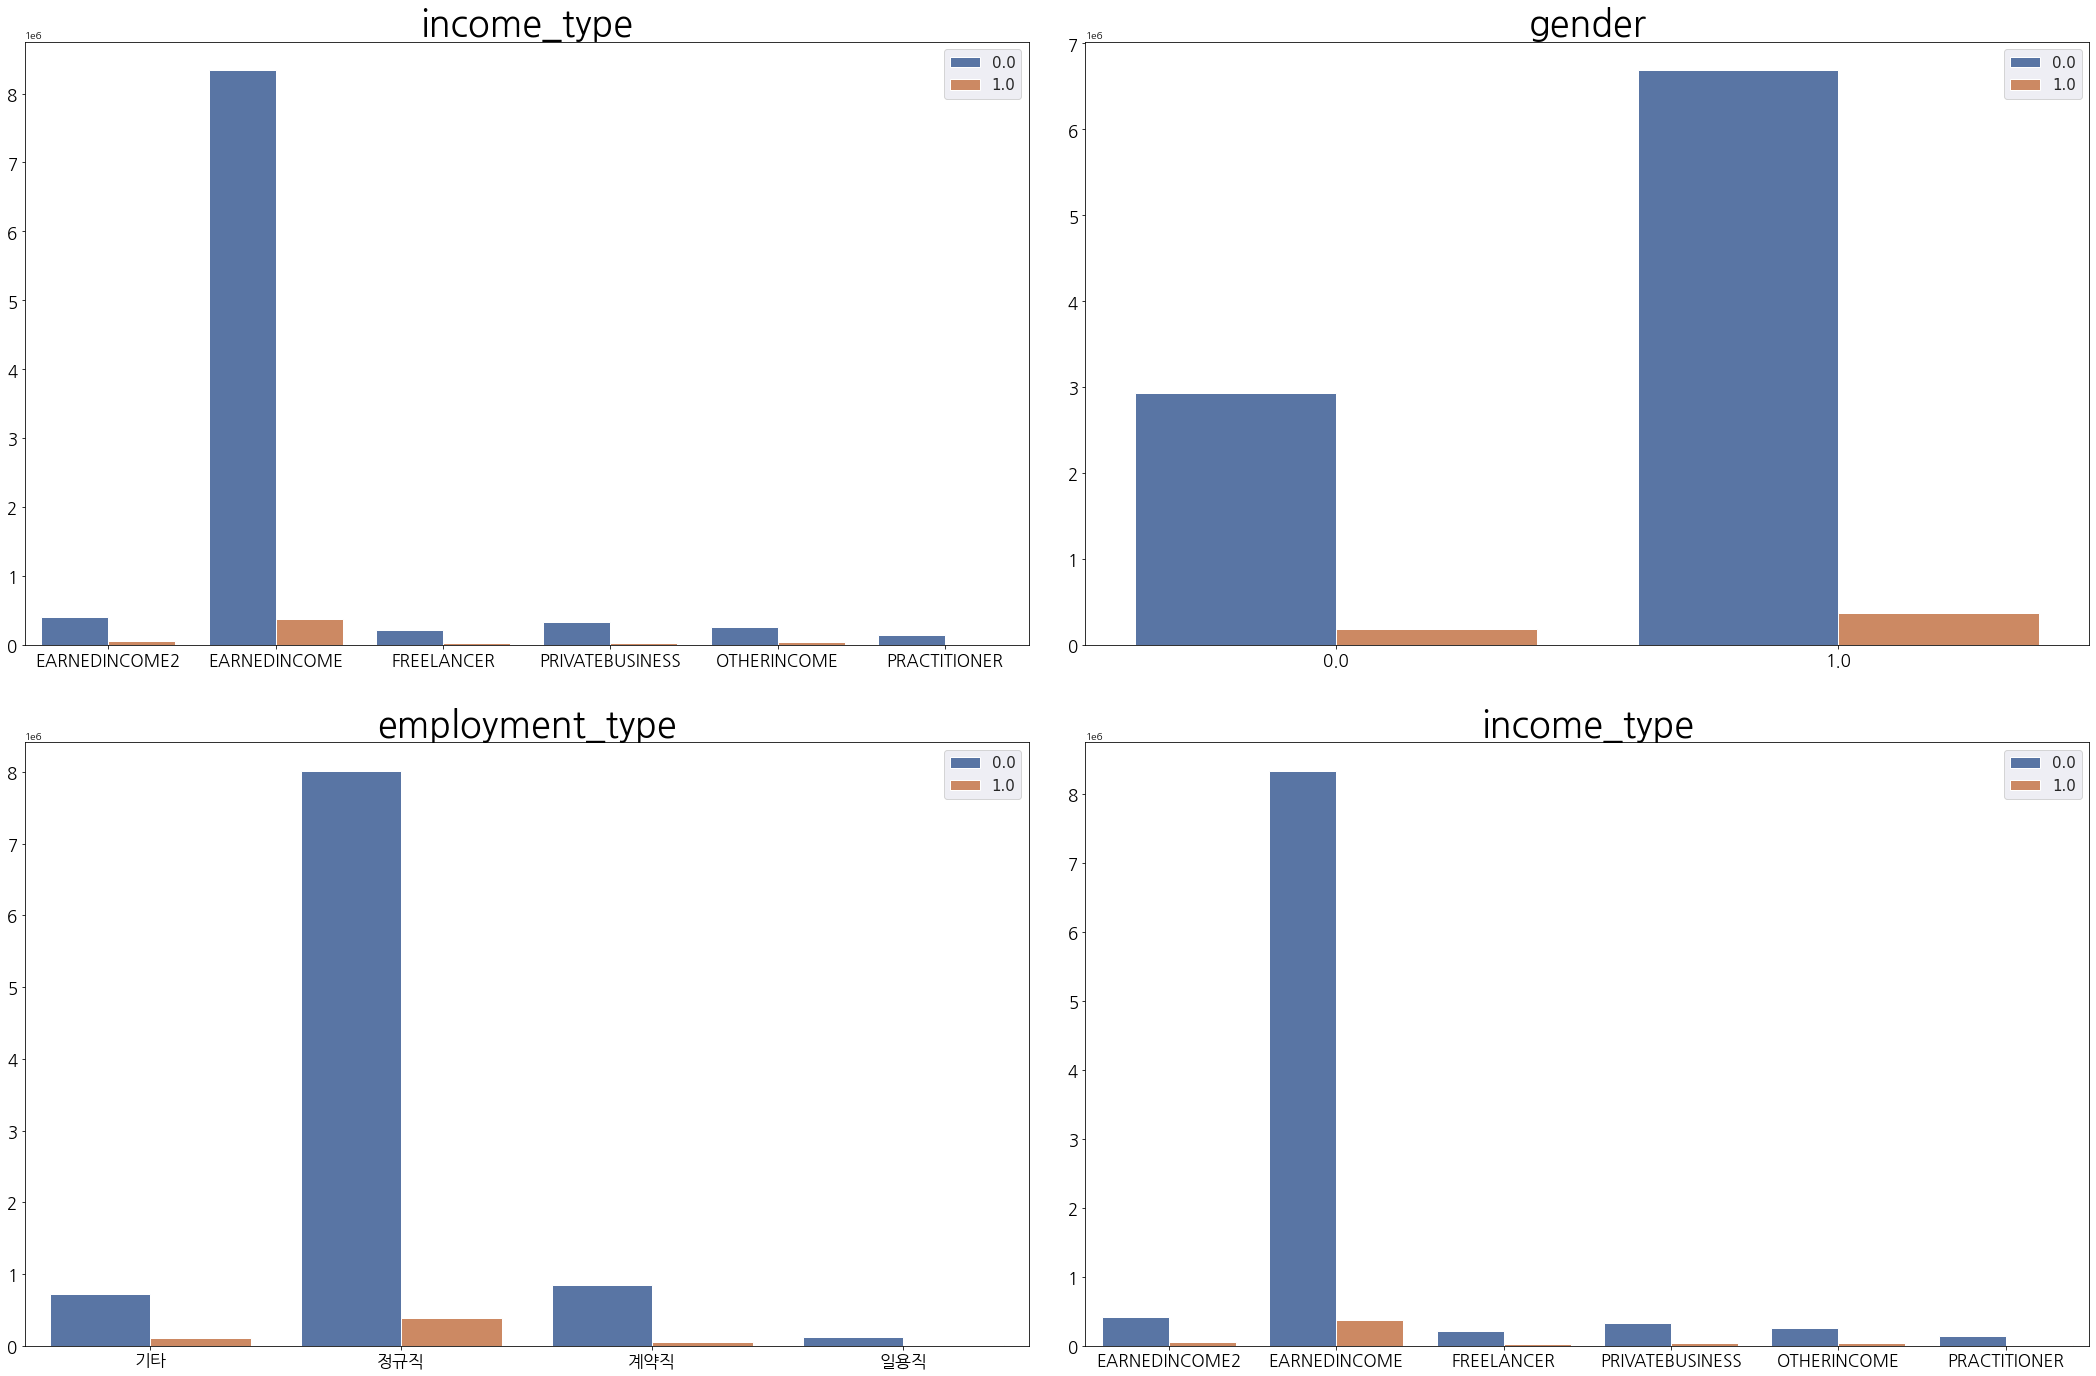

In [5]:
fig, axes = plt.subplots(2,2, figsize=(30,20))

sns.set(font_scale=3)
sns.countplot(x='income_type',hue=train['is_applied'], data=train, ax=axes[0][0]).set(title='income_type')
sns.countplot(x='gender',hue=train['is_applied'], data=train, ax=axes[0][1]).set(title='gender')
sns.countplot(x='employment_type',hue=train['is_applied'], data=train, ax=axes[1][0]).set(title='employment_type')
sns.countplot(x='income_type',hue=train['is_applied'], data=train, ax=axes[1][1]).set(title='income_type')

for i in np.arange(0,2):
    for j in np.arange(0,2):
        axes[i][j].set(ylabel=None)
        axes[i][j].set(xlabel=None)
        axes[i][j].tick_params(labelsize=17)
        axes[i][j].legend(loc='upper right',fontsize='15')

plt.tight_layout()
plt.show()

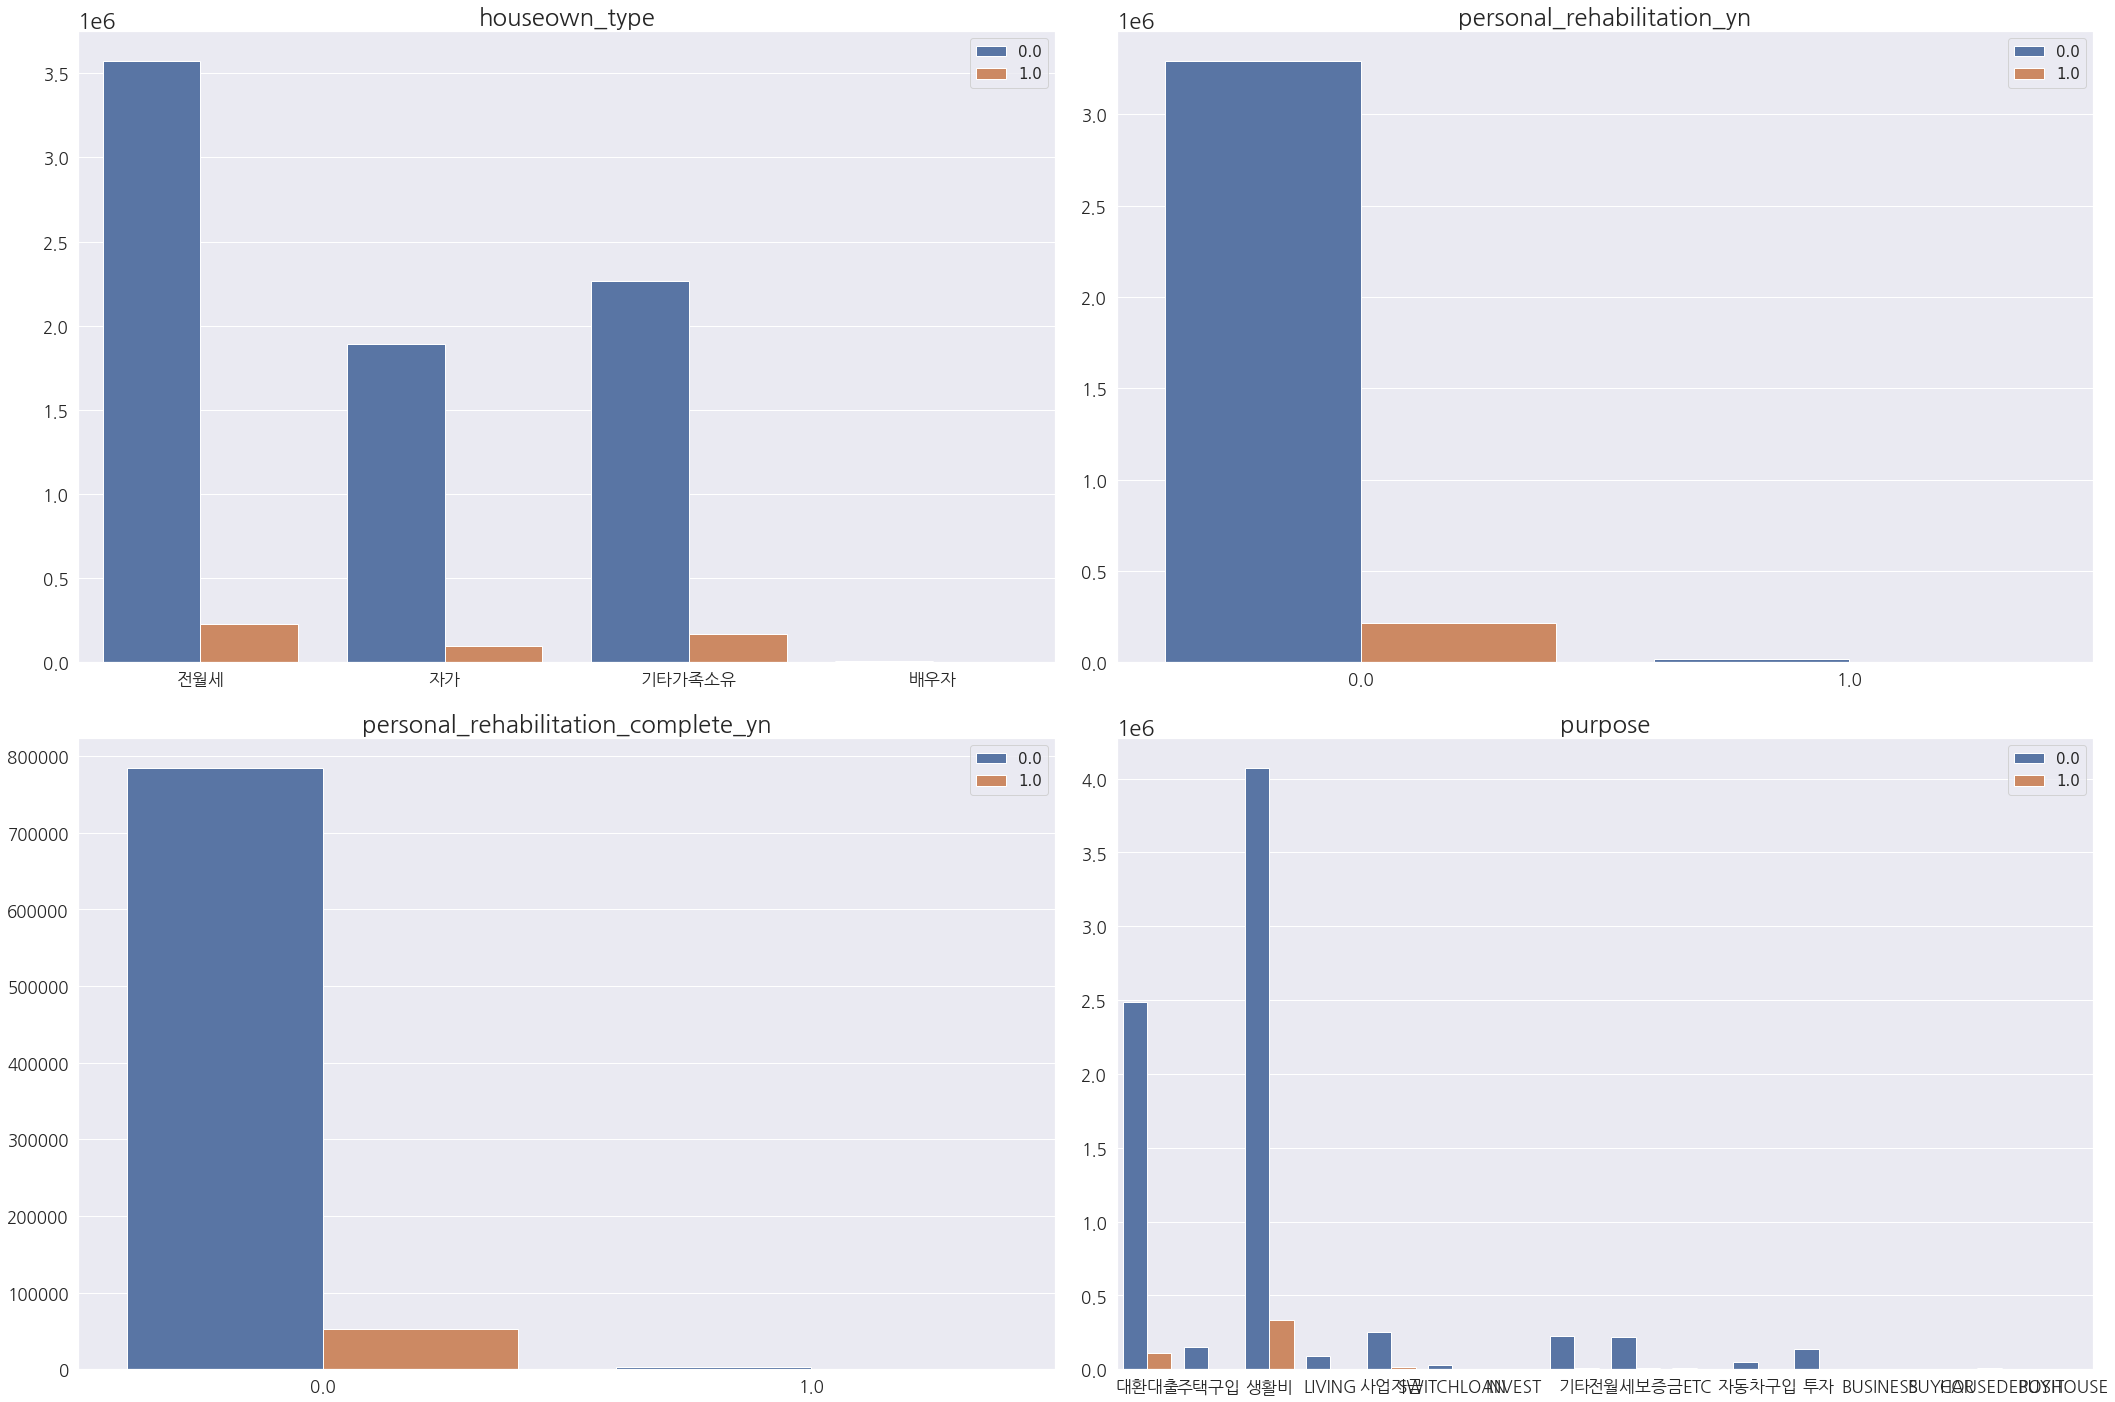

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(30,20))

sns.set(font_scale=2)
sns.countplot(x='houseown_type',hue=train['is_applied'], data=train, ax=axes[0][0]).set(title='houseown_type')
sns.countplot(x='personal_rehabilitation_yn',hue=train['is_applied'], data=train, ax=axes[0][1]).set(title='personal_rehabilitation_yn')
sns.countplot(x='personal_rehabilitation_complete_yn',hue=train['is_applied'], data=train, ax=axes[1][0]).set(title='personal_rehabilitation_complete_yn')
sns.countplot(x='purpose',hue=train['is_applied'], data=train, ax=axes[1][1]).set(title='purpose')

for i in np.arange(0,2):
    for j in np.arange(0,2):
        axes[i][j].set(ylabel=None)
        axes[i][j].set(xlabel=None)
        axes[i][j].tick_params(labelsize=17)
        axes[i][j].legend(loc='upper right',fontsize='15')

plt.tight_layout()
plt.show()

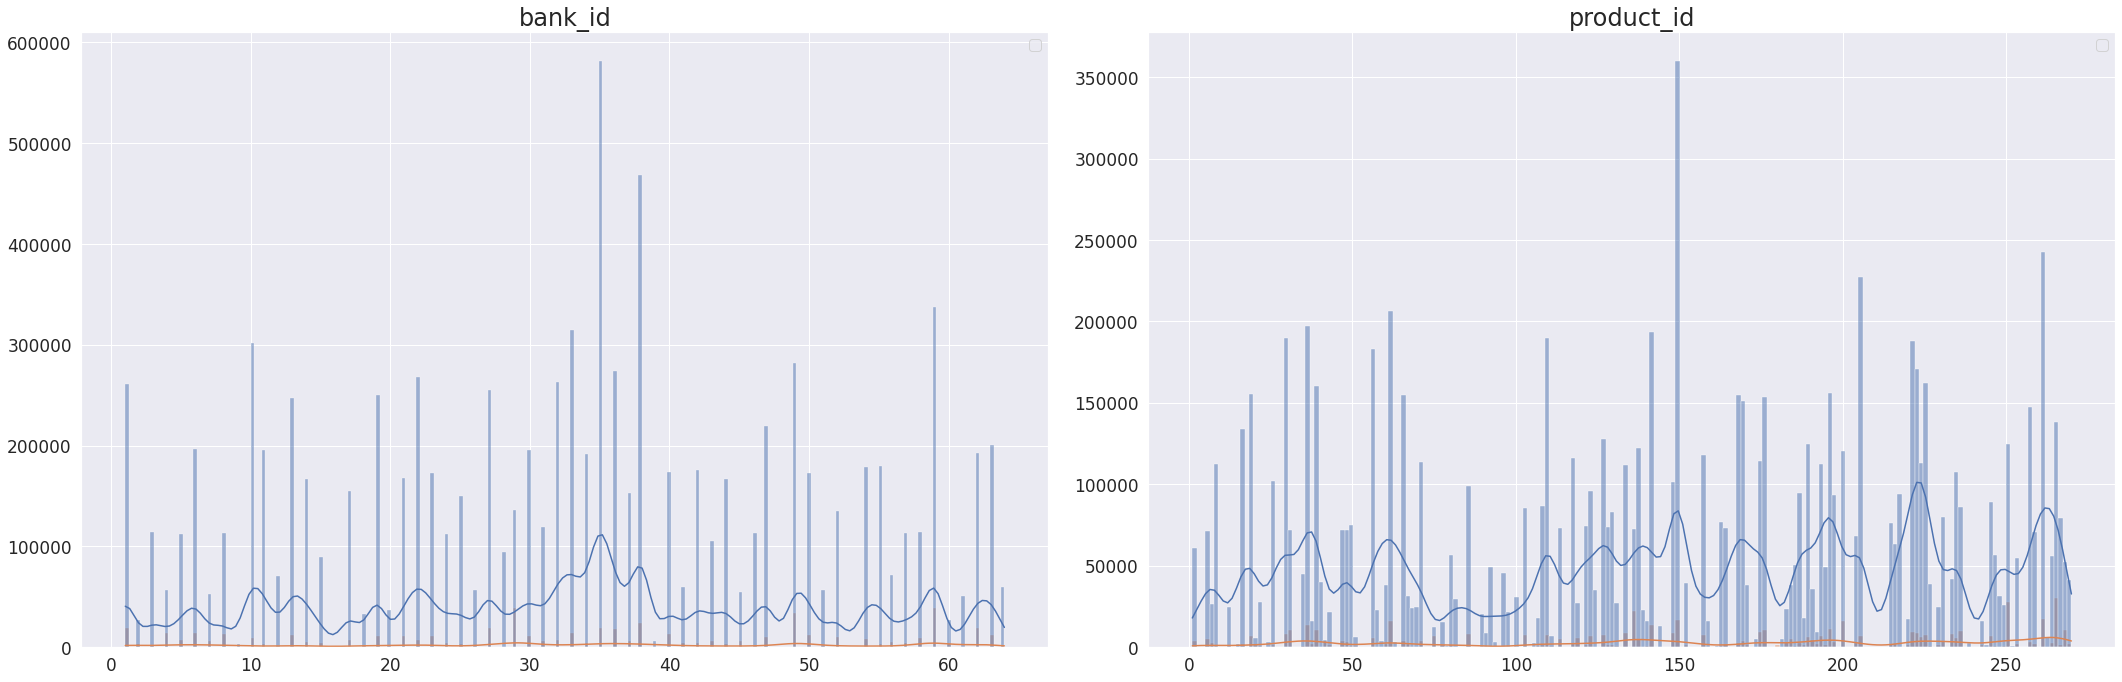

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(30,10))

sns.set(font_scale=2)
sns.histplot(x='bank_id',kde=True,hue=train['is_applied'], data=train, ax=axes[0]).set(title='bank_id')
sns.histplot(x='product_id',kde=True,hue=train['is_applied'], data=train, ax=axes[1]).set(title='product_id')

for i in np.arange(0,2):
  axes[i].set(ylabel=None)
  axes[i].set(xlabel=None)
  axes[i].tick_params(labelsize=17)
  axes[i].legend(loc='upper right',fontsize='15')

plt.tight_layout()
plt.show()

### 수치형

## 수치형 데이터 시각화 - 총 7개 칼럼
### yearly_income, desired_amount, loan_limit는 이상치 처리 후 시각화

loan_limit 비정상적인 값 제거

In [7]:
# 승인 한도가 99억 이상인 값 제거
idx = train[train['loan_limit']>9900000000].index
train.drop(idx, axis=0, inplace=True)
train.reset_index(drop=True, inplace =True)

In [8]:
# 입사년월이 비정상적으로 기록된 값 삭제
idx = train[(train['company_enter_month'] - train['birth_year'] *100) < 20].index
train.drop(index= idx, inplace=True)

# 2022년 6월 이후의 입사년월 삭제
idx_ = train[train['company_enter_month']>=202206].index
train.drop(index= idx_, inplace=True)

def get_outlier(df=None, column=None, weight=1.5):
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

# 함수 사용해서 이상치 값 삭제
outlier_list = ['yearly_income','desired_amount','loan_limit']

for i in outlier_list:
    oulier_idx = get_outlier(df=train, column=i, weight=1.5)
    train.drop(oulier_idx, axis=0, inplace=True)

train.reset_index(drop=True, inplace =True)

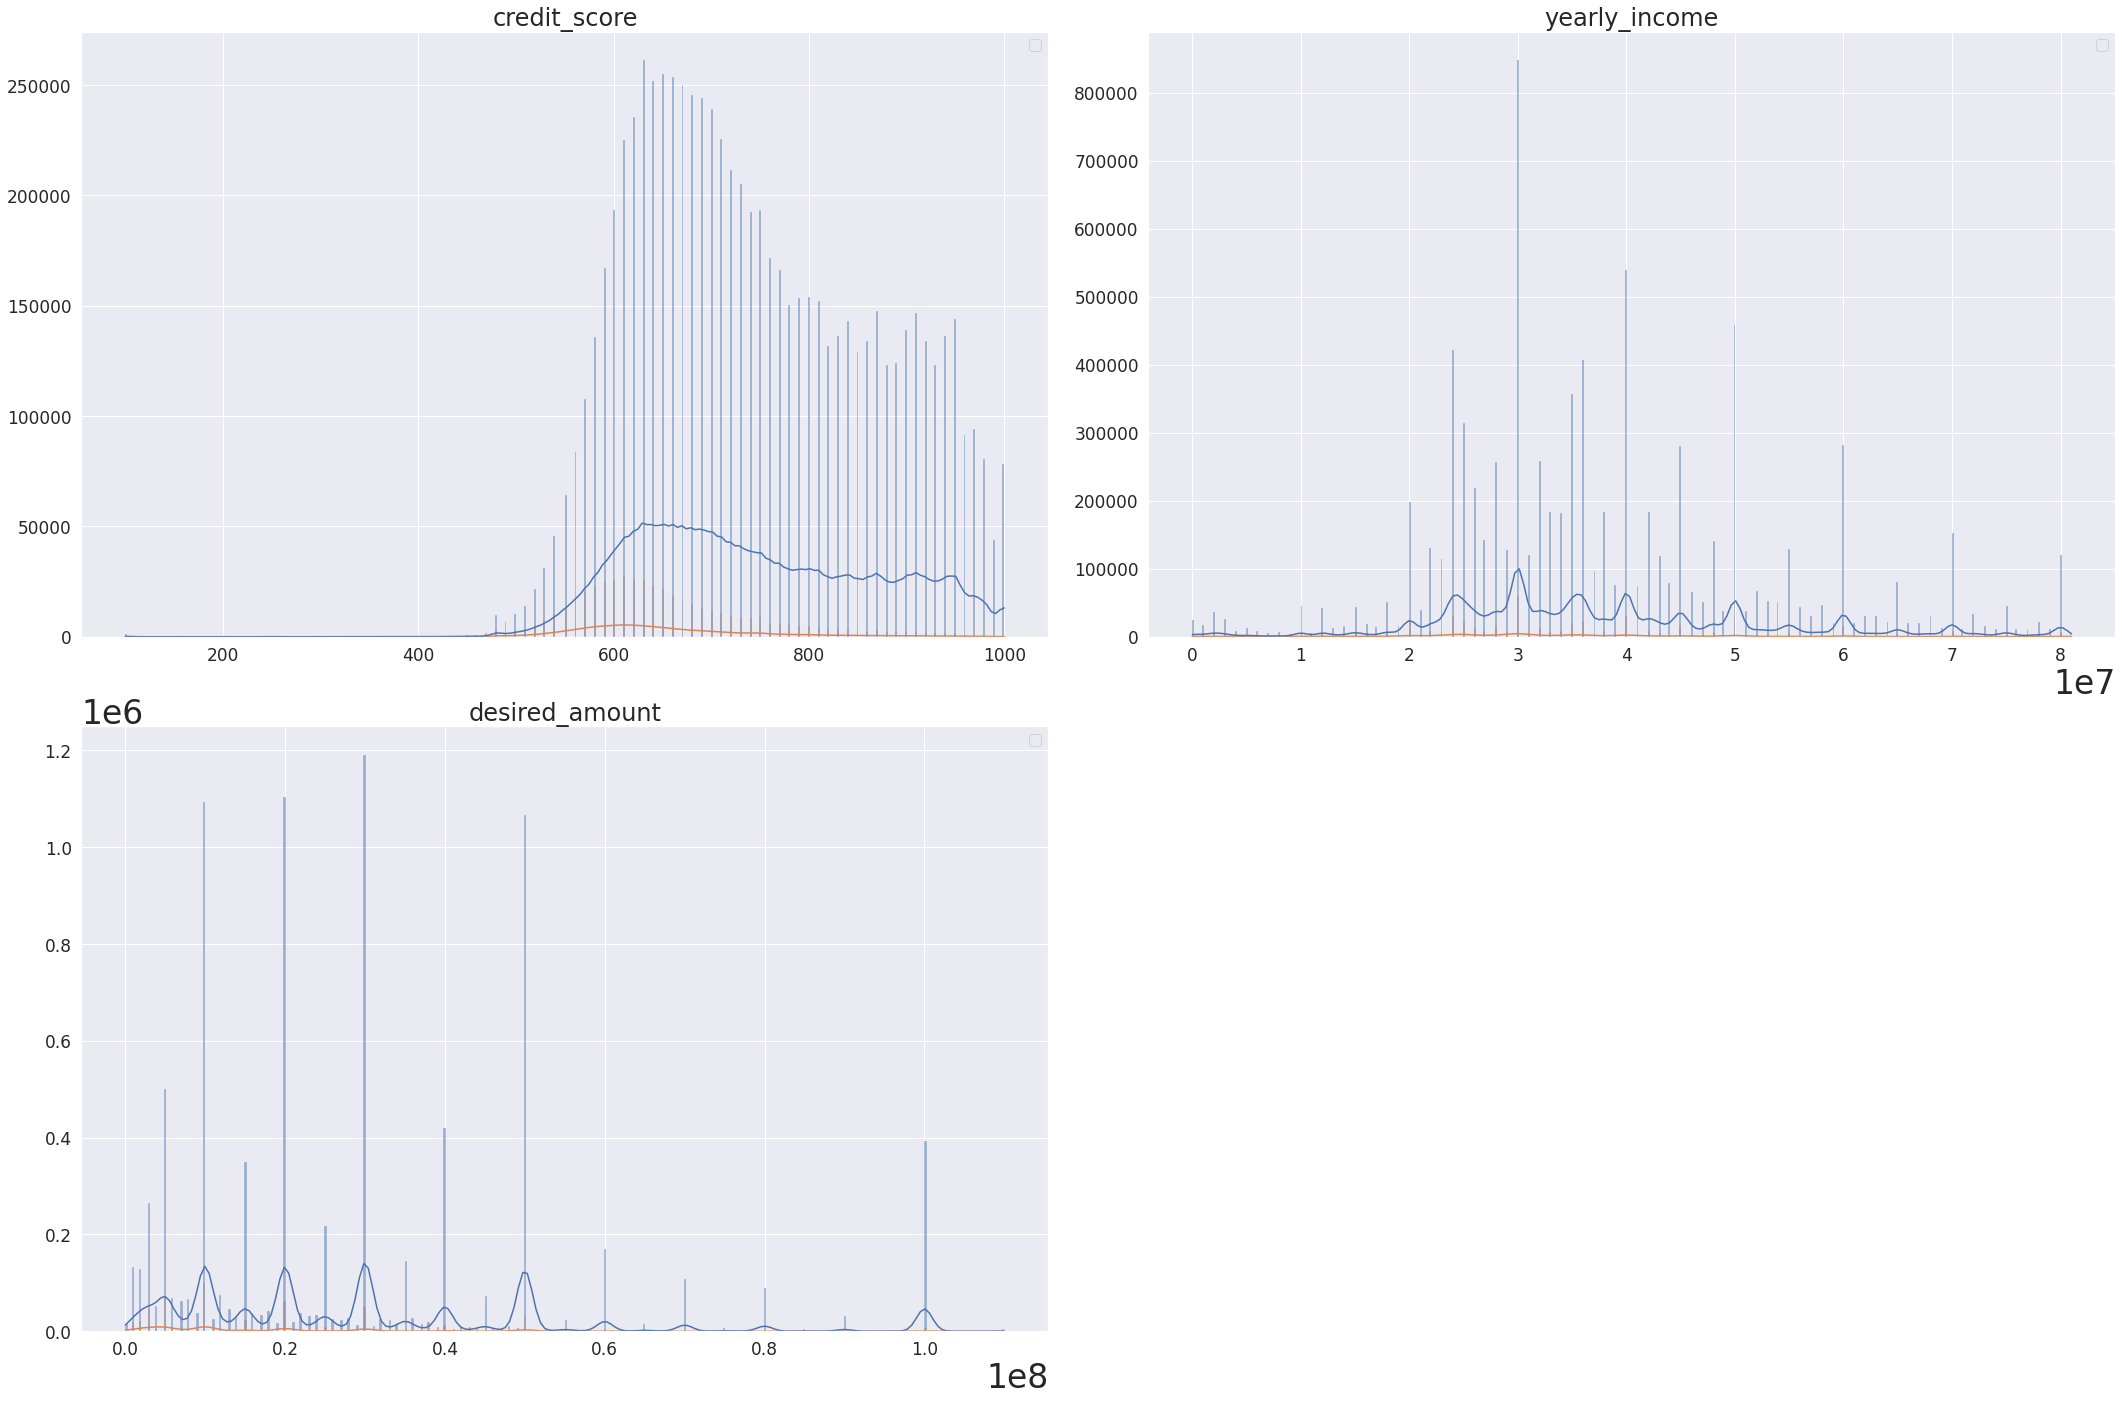

In [9]:
fig, axes = plt.subplots(2,2, figsize=(30,20))

sns.set(font_scale=2)
sns.histplot(x='credit_score',kde=True,hue=train['is_applied'], data=train, ax=axes[0][0]).set(title='credit_score')
sns.histplot(x='yearly_income',kde=True,hue=train['is_applied'], data=train, ax=axes[0][1]).set(title='yearly_income')
sns.histplot(x='desired_amount',kde=True,hue=train['is_applied'], data=train, ax=axes[1][0]).set(title='desired_amount')

for i in np.arange(0,2):
    for j in np.arange(0,2):
        axes[i][j].set(ylabel=None)
        axes[i][j].set(xlabel=None)
        axes[i][j].tick_params(labelsize=17)
        axes[i][j].legend(loc='upper right',fontsize='15')

fig.delaxes(axes[1][1])
plt.tight_layout()
plt.show()

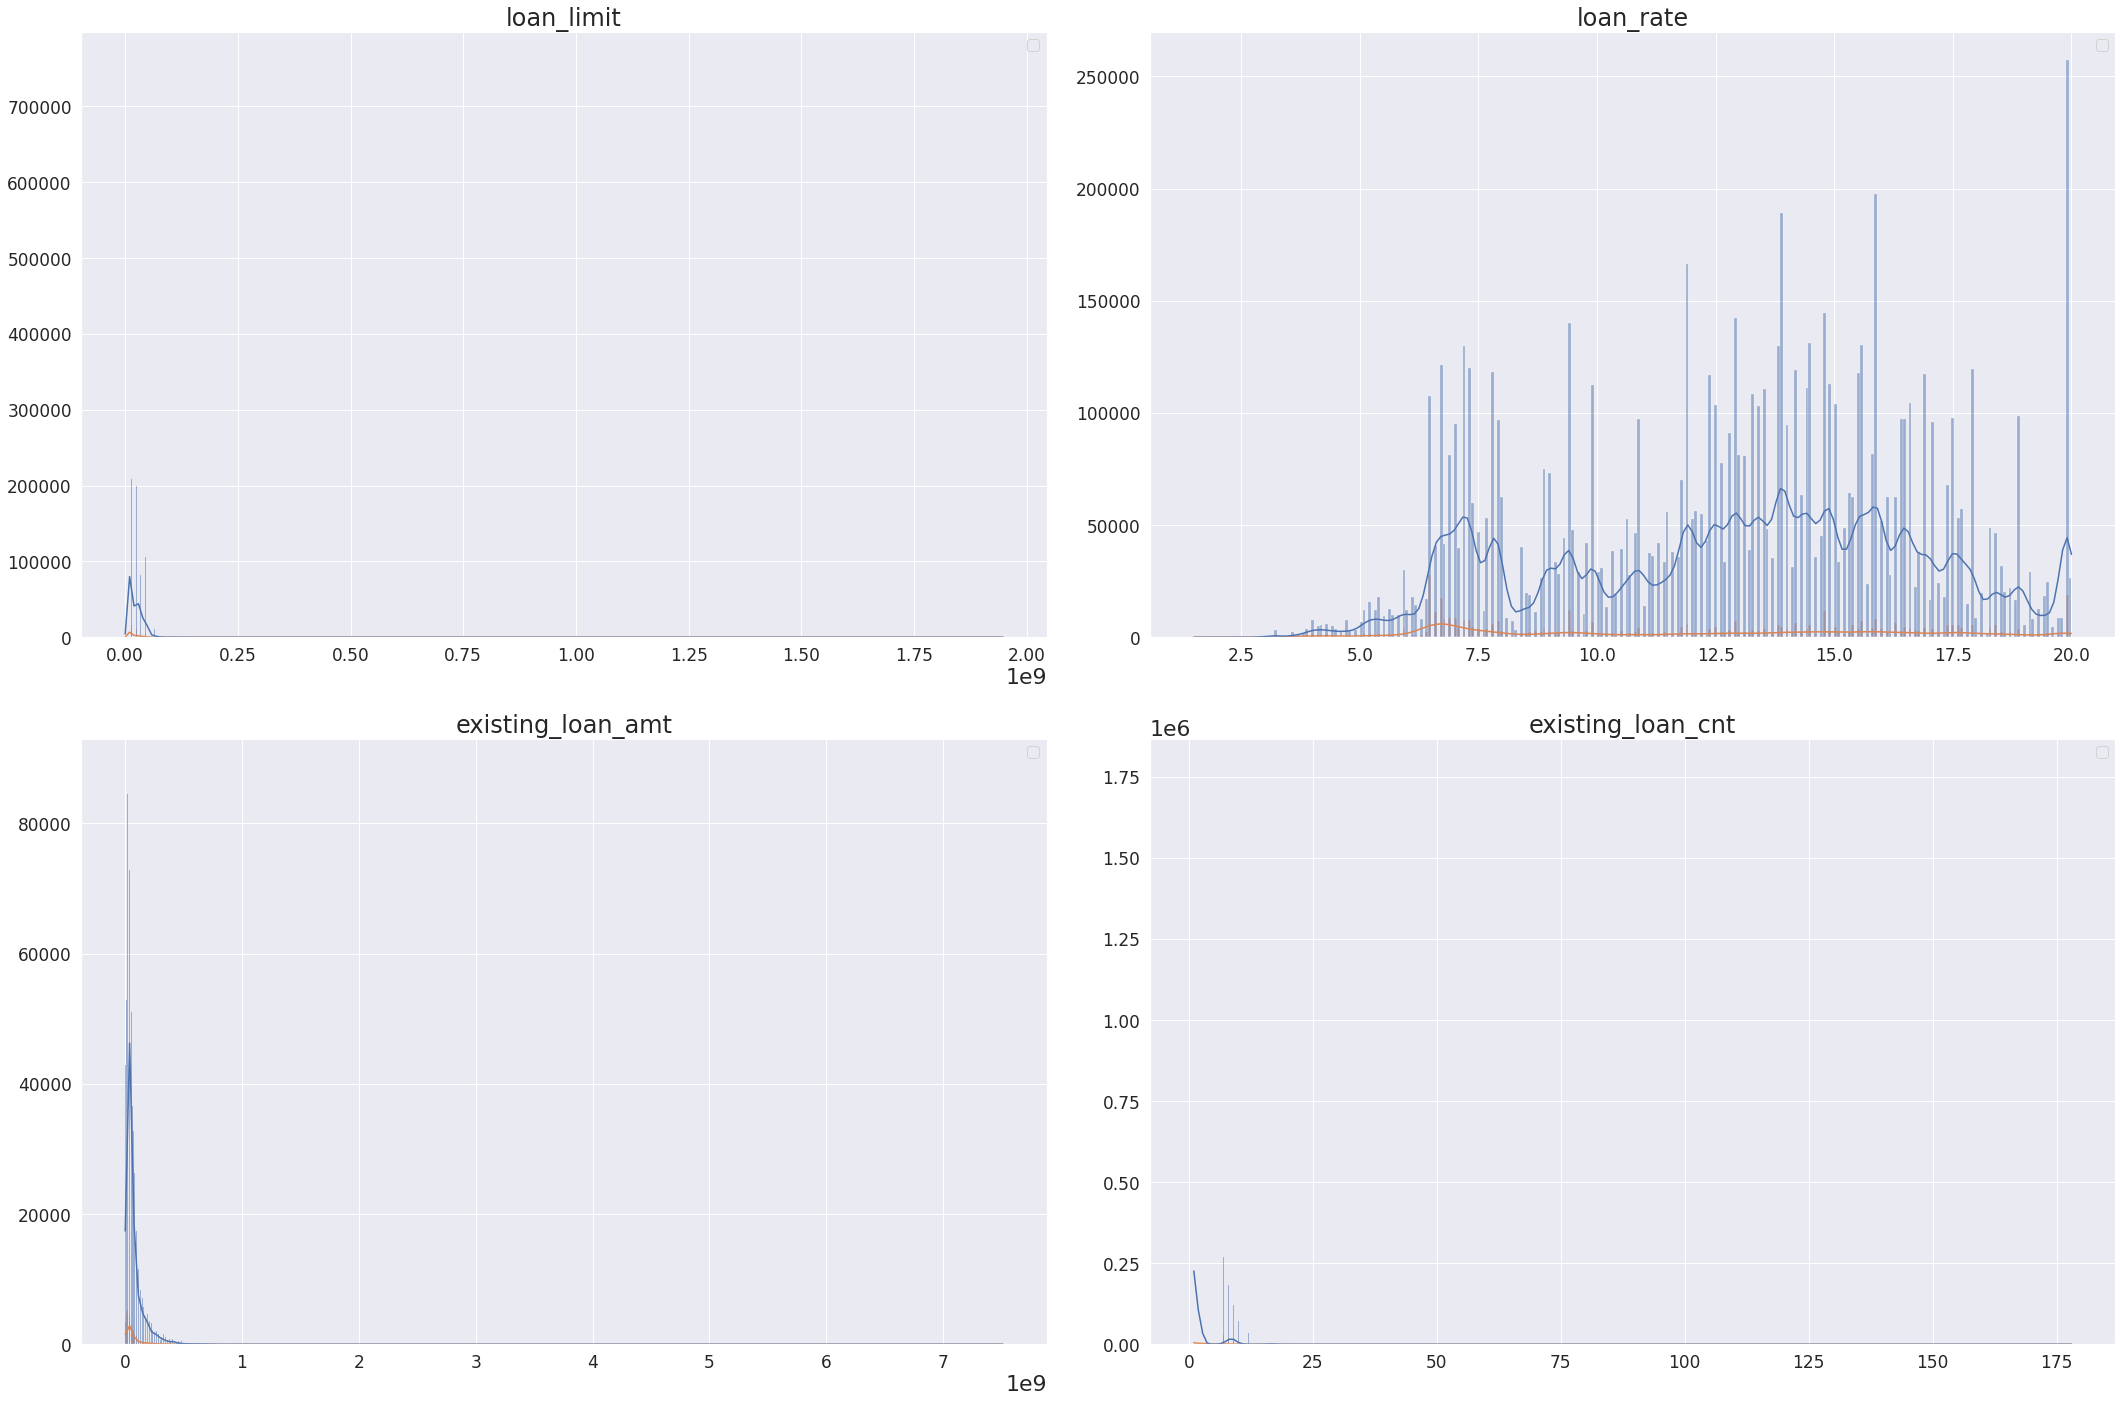

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(30,20))

sns.set(font_scale=2)
sns.histplot(x='loan_limit',kde=True,hue=train['is_applied'], data=train, ax=axes[0][0]).set(title='loan_limit')
sns.histplot(x='loan_rate',kde=True,hue=train['is_applied'], data=train, ax=axes[0][1]).set(title='loan_rate')
sns.histplot(x='existing_loan_amt',kde=True,hue=train['is_applied'], data=train, ax=axes[1][0]).set(title='existing_loan_amt')
sns.histplot(x='existing_loan_cnt',kde=True,hue=train['is_applied'], data=train, ax=axes[1][1]).set(title='existing_loan_cnt')

for i in np.arange(0,2):
    for j in np.arange(0,2):
        axes[i][j].set(ylabel=None)
        axes[i][j].set(xlabel=None)
        axes[i][j].tick_params(labelsize=17)
        axes[i][j].legend(loc='upper right',fontsize='15')

plt.tight_layout()
plt.show()

## 이상치 처리 후 boxplot

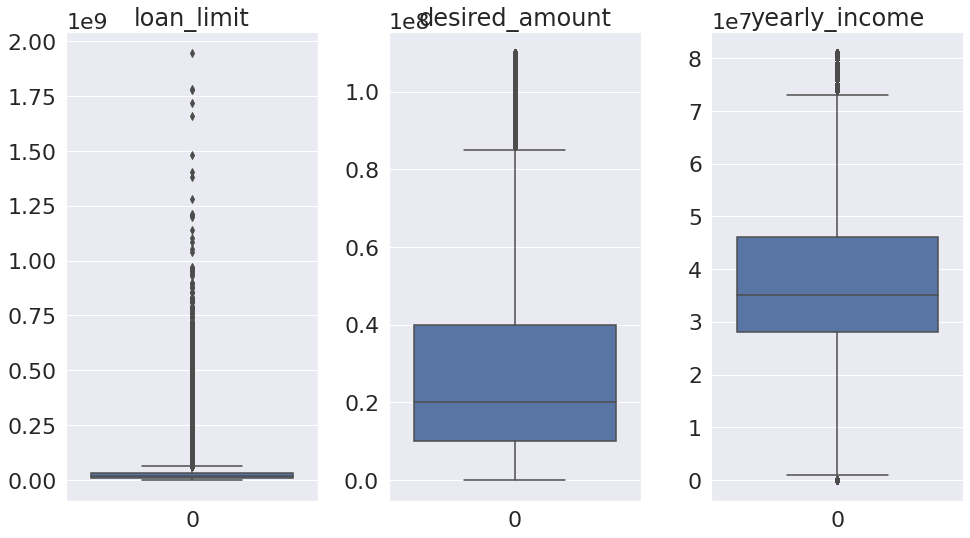

In [10]:
fig, axes = plt.subplots(ncols = 3, figsize=(14,8))

sns.boxplot(data=train['loan_limit'], ax=axes[0]).set(title='loan_limit')
sns.boxplot(data=train['desired_amount'], ax=axes[1]).set(title='desired_amount')
sns.boxplot(data=train['yearly_income'], ax=axes[2]).set(title='yearly_income')
plt.tight_layout()
plt.show()

# -------파생변수 생성 후 시각화 추가-------

### 범주형

## bank_rank 파생변수 생성

is_applied가 1인 데이터 중 bank_id의 개수가 제일 많은 순서대로 그룹화하여 순위를 결정한 뒤 bank_rank 변수 생성

In [ ]:
train['bank_rank'] = 0

In [ ]:
bank_list = [59, 29, 49, 38]

for i in bank_list:
    idx = train[train['bank_id'].isin([i])]['bank_id'].index
    train.loc[idx,'bank_rank'] = 6

In [ ]:
bank_list = [2, 35, 27, 1, 36]

for i in bank_list:
    idx = train[train['bank_id'].isin([i])]['bank_id'].index
    train.loc[idx,'bank_rank'] = 5

In [ ]:
bank_list = [4, 33, 6, 40, 8, 63, 50, 13, 19, 21, 23, 30, 47, 52]

for i in bank_list:
    idx = train[train['bank_id'].isin([i])]['bank_id'].index
    train.loc[idx,'bank_rank'] = 4

In [ ]:
bank_list = [58, 10, 54, 22, 32, 17, 5, 31, 43, 45, 7, 37]

for i in bank_list:
    idx = train[train['bank_id'].isin([i])]['bank_id'].index
    train.loc[idx,'bank_rank'] = 3

In [ ]:
bank_list = [14, 56, 41, 42, 15, 24, 34,57, 44, 60, 11, 25, 55, 2, 64, 18, 3, 26, 20, 46, 51, 12]

for i in bank_list:
    idx = train[train['bank_id'].isin([i])]['bank_id'].index
    train.loc[idx,'bank_rank'] = 2

In [ ]:
bank_list = [61, 39, 9, 28, 16]

for i in bank_list:
    idx = train[train['bank_id'].isin([i])]['bank_id'].index
    train.loc[idx,'bank_rank'] = 1

## credit_loan_rate 파생변수 생성

외부데이터에서 신용점수 별 대출금리의 평균을 구한 뒤 각 신용점수 구간에 해당하는 lona_rate와 비교하여 loan_rate가 더 높을 경우 0, 낮을 경우 1의 값을 할당

In [ ]:
train['credit_loan_rate']= 1

In [ ]:
score300 = (16.99+18.45)/2
score400 = 19.9
score500 = (19.18+19.9+19.9)/3
score600 = (19.9+14.37+18.27+15.78+17.9+17.57+14.65+19.13+10.9+18.5+16.86+18.79)/12
score700 = (19.59+14.29+16.71+14.89+14.53+16.81+14.14+18.74+12.25+18.25+16.12+16.12)/12
score800 = (16.18+11.71+13.03+15.57+13.59+13.02+15.58+12.82+17.53+11.65+17.55+14.68+14.26)/13
score900 = (13.90+11.87+10.7+14.54+12.69+12.75+13.51+11.83+15.75+10.71+15.53+12.89+12.75)/13
score1000 = (12.62+11.26+9.28+13.05+12.22+10.45+11.29+10.60+12.21+10.25+12.92+11.43+11.50)/13

In [ ]:
cond1 = (train['credit_score'] <= 300) & (train['loan_rate'] > score300)
cond2 = (train['credit_score'] > 300) & (train['credit_score'] <= 400) & (train['loan_rate'] > score400)
cond3 = (train['credit_score'] > 400) & (train['credit_score'] <= 500) & (train['loan_rate'] > score500)
cond4 = (train['credit_score'] > 500) & (train['credit_score'] <= 600) & (train['loan_rate'] > score600)
cond5 = (train['credit_score'] > 600) & (train['credit_score'] <= 700) & (train['loan_rate'] > score700)
cond6 = (train['credit_score'] > 700) & (train['credit_score'] <= 800) & (train['loan_rate'] > score800)
cond7 = (train['credit_score'] > 800) & (train['credit_score'] <= 900) & (train['loan_rate'] > score900)
cond8 = (train['credit_score'] > 900) & (train['loan_rate'] > score1000)

In [ ]:
train['credit_loan_rate'] = np.where(cond1,0,np.where(cond2,0,np.where(cond3,0,np.where(cond4,0,np.where(cond5,0,np.where(cond6,0,np.where(cond7,0,np.where(cond8,0,1))))))))

## over_desired 파생변수 생성

In [ ]:
condition_tr =((train['desired_amount'] - train['loan_limit']) >=0)
train['over_desired']=np.where(condition_tr,0,1)

## 생년월인 -> 나이로 변환

In [ ]:
# 생년월일 -> 나이로 교체
train['age'] = 2022 - train['birth_year'] + 1
train.drop('birth_year', axis = 1, inplace = True)

## age를 범주화하여 age_level 생성

모든 기준은 대한민국 평균 연령로 결정  
1) 평균 취업 연령 : 28세  
2) 평균 결혼 및 출산 연령 : 32세  
3) 평균 내 집 마련 연령 : 40세  
4) 평균 은퇴 연령 : 60세   
를 이용해 age를 범주화하여 age_level 생성

In [ ]:
condition1 = (train['age'] < 28)
condition2 = (train['age'] >= 28) & (train['age'] < 32)
condition3 = (train['age'] >= 32) & (train['age'] < 40)
condition4 = (train['age'] >= 40) & (train['age'] < 60)
condition5 = (train['age'] >= 60)

In [ ]:
train['age_level'] = np.where(condition1, 0, np.where(condition2,1,np.where(condition3,2,np.where(condition4,3,np.where(condition5,4,"NaN")))))

In [ ]:
train.drop(['age'],axis= 1, inplace=True)

## admission_count 변수생성

In [ ]:
train = train.reset_index(drop=True)
train_sort = train.sort_values('application_id')
admission_count = pd.DataFrame(train['application_id'].value_counts().sort_index())
admission_count.columns = ['admission_count']
admission_count.index.name = 'application_id'
admission_count = admission_count.reset_index()
train = pd.merge(train_sort, admission_count)

## 파생변수 생성 시각화

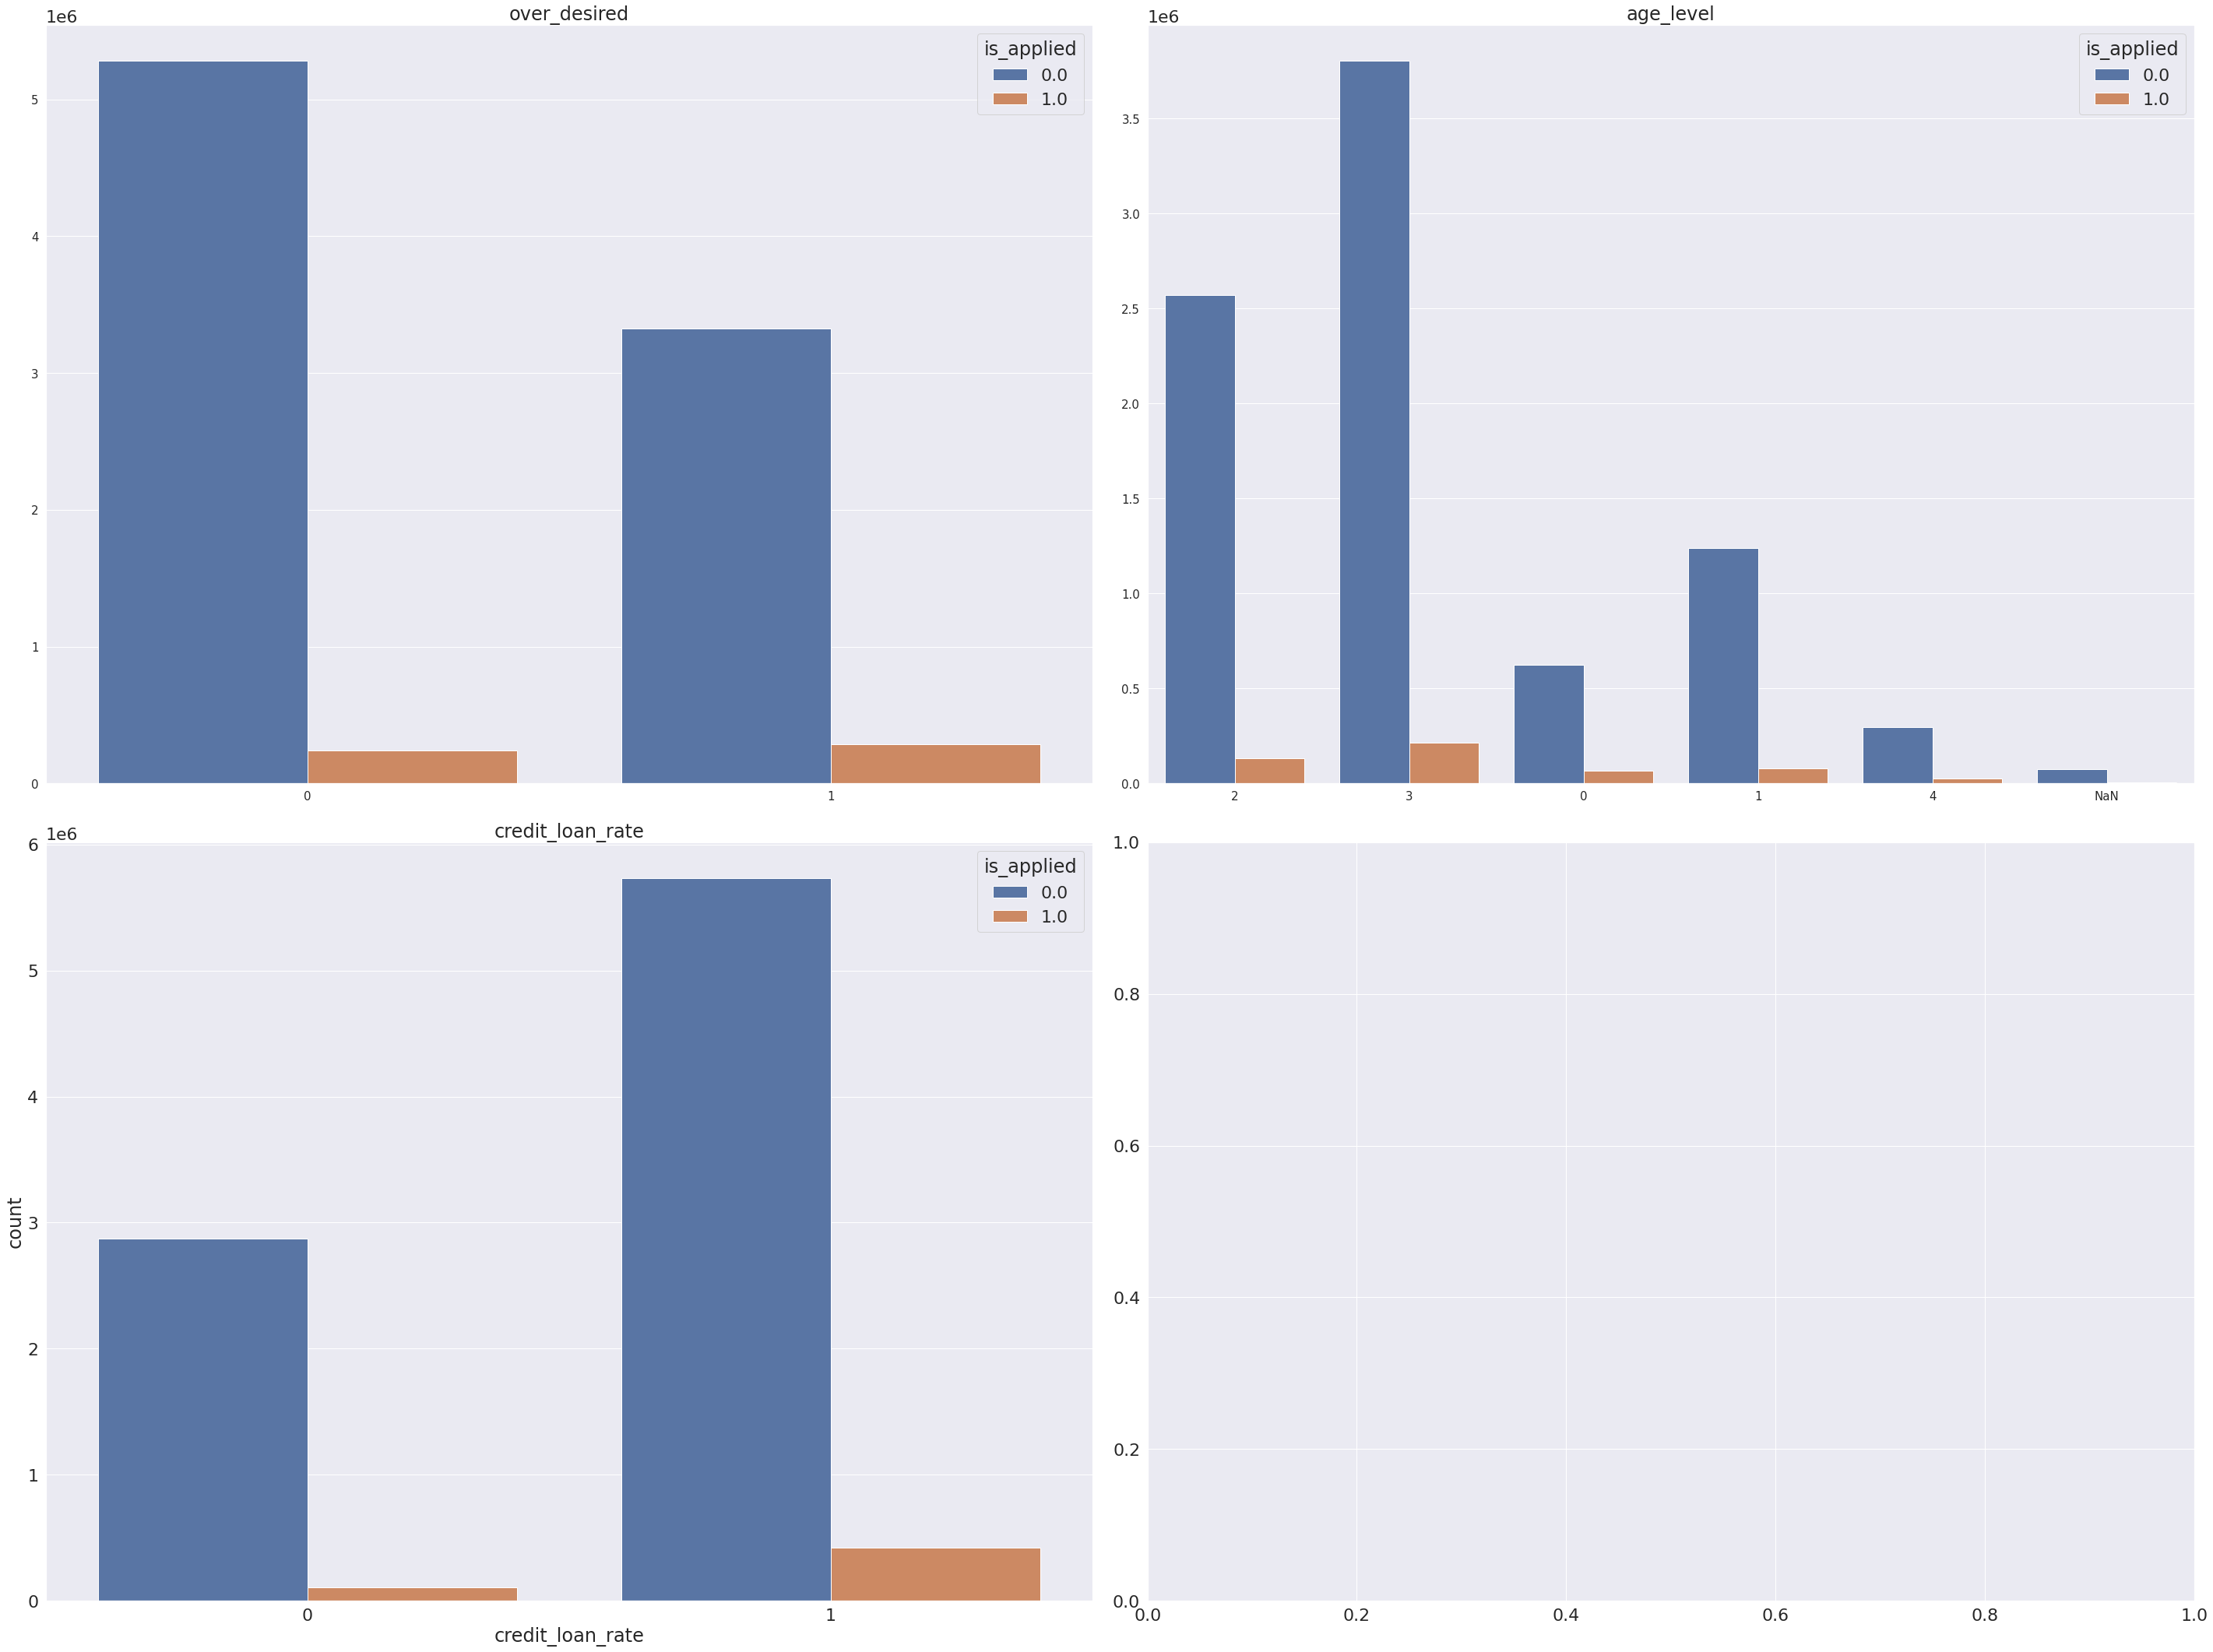

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(40,30))

sns.set(font_scale=2)
sns.countplot(x=train['over_desired'],hue=train['is_applied'],ax=axes[0][0]).set(title='over_desired')
sns.countplot(x=train['age_level'],hue=train['is_applied'],ax=axes[0][1]).set(title='age_level')
sns.countplot(x=train['credit_loan_rate'],hue=train['is_applied'],ax=axes[1][0]).set(title='credit_loan_rate')

for i in np.arange(0,1):
    for j in np.arange(0,2):
        axes[i][j].set(ylabel=None)
        axes[i][j].set(xlabel=None)
        axes[i][j].tick_params(labelsize=15)


plt.tight_layout()
plt.show()

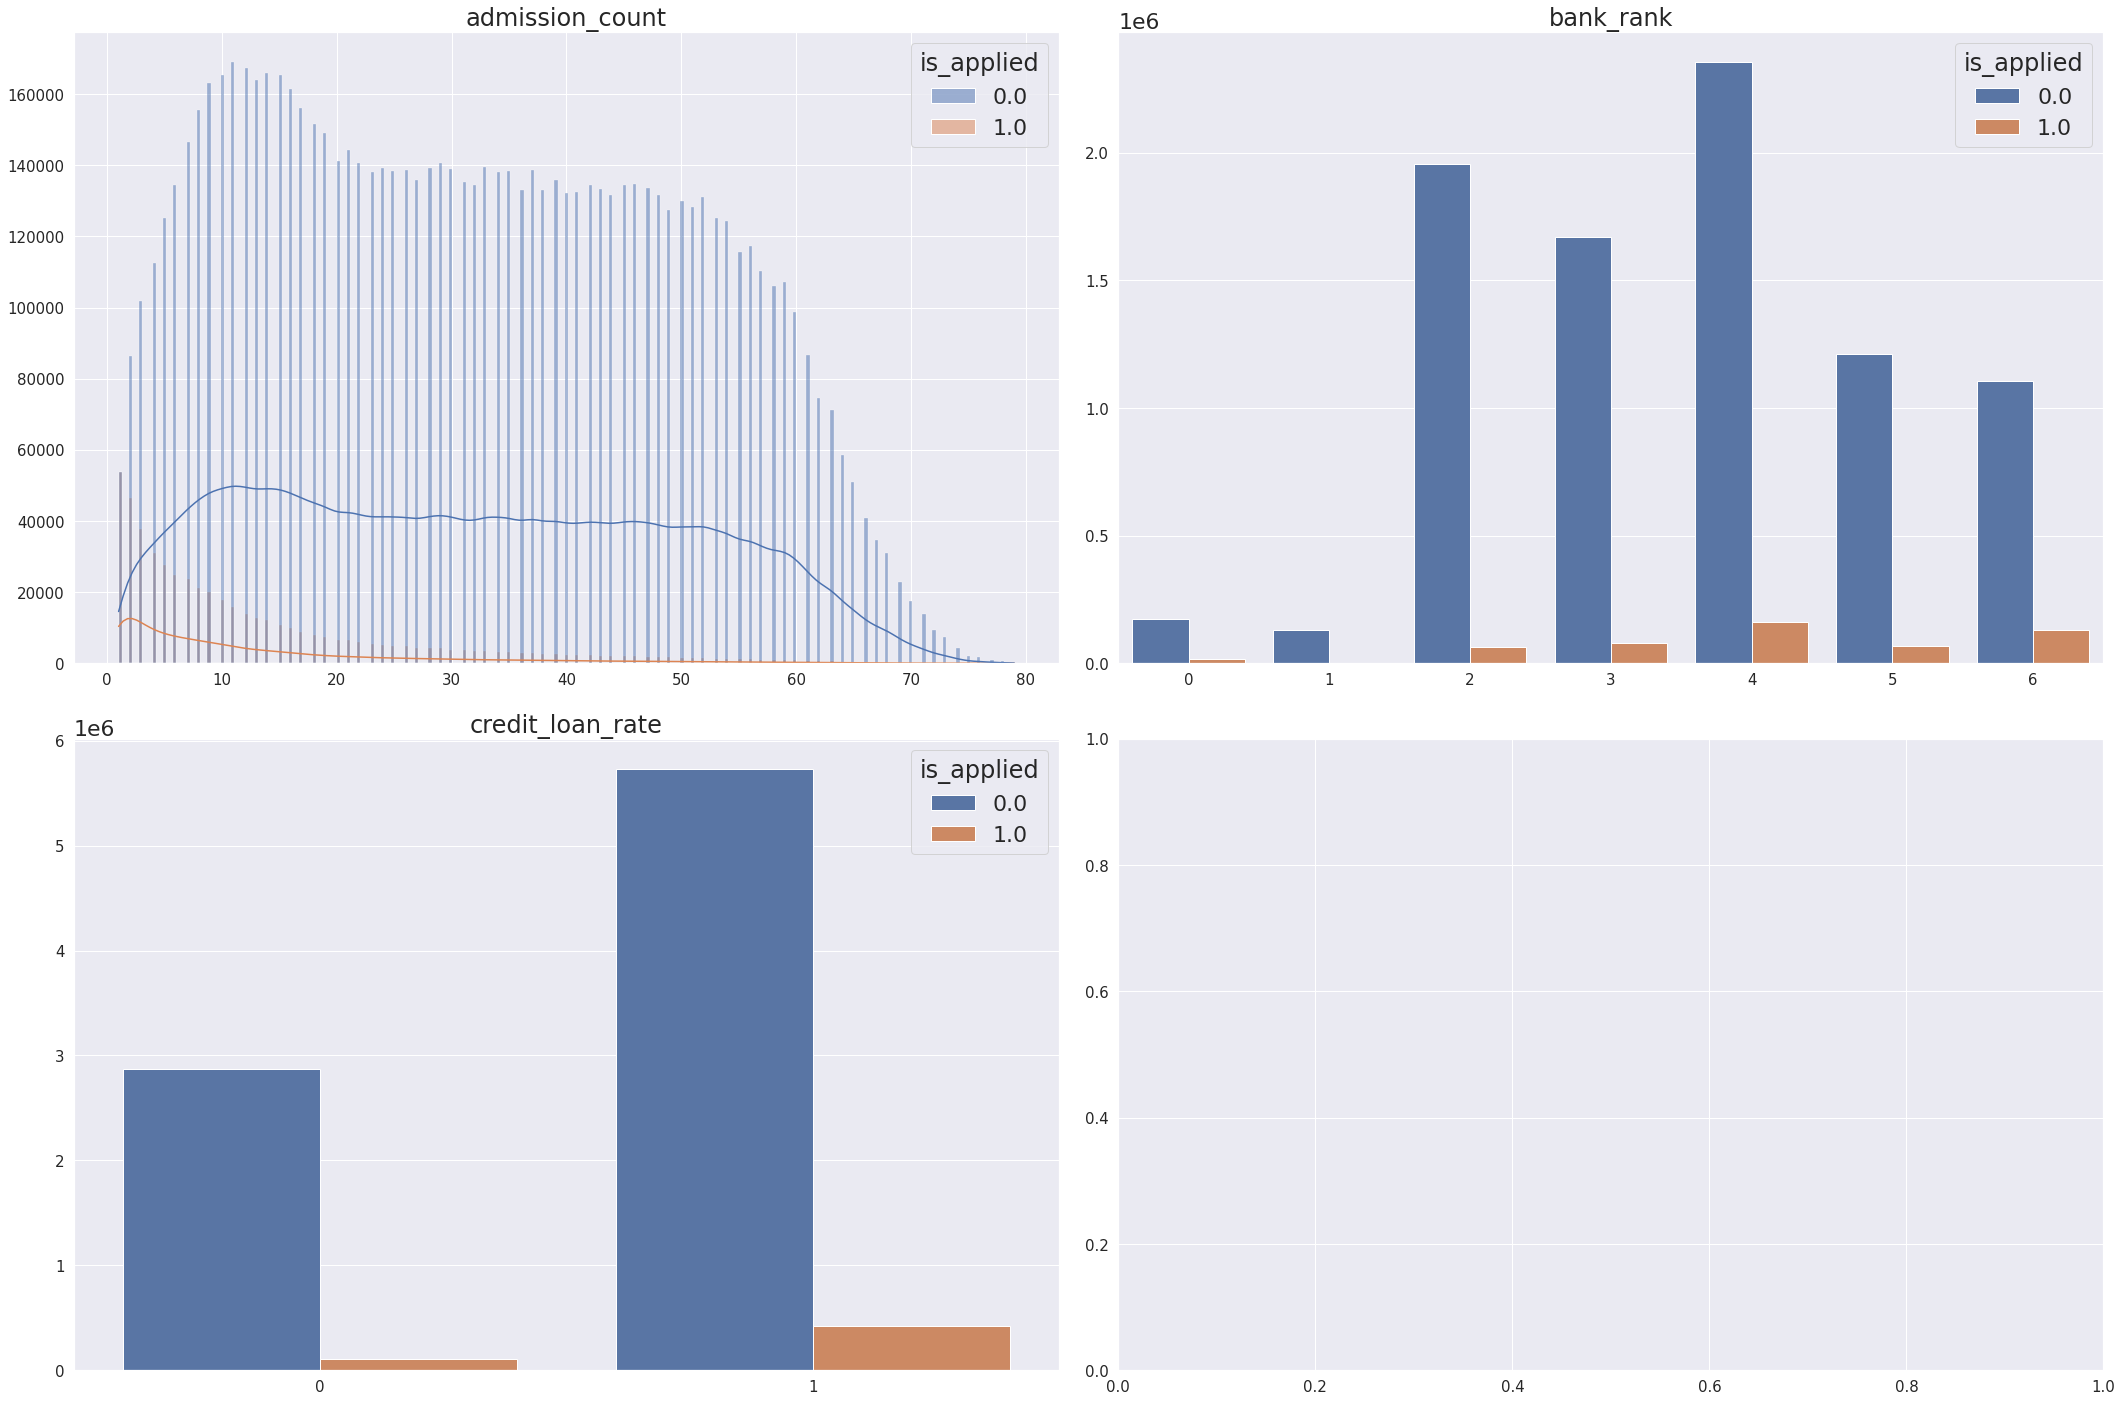

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(30,20))

sns.set(font_scale=2)
sns.histplot(x=train['admission_count'],kde=True,hue=train['is_applied'],ax=axes[0][0]).set(title='admission_count')
sns.countplot(x=train['bank_rank'],hue=train['is_applied'],ax=axes[0][1]).set(title='bank_rank')
sns.countplot(x=train['credit_loan_rate'],hue=train['is_applied'],ax=axes[1][0]).set(title='credit_loan_rate')

for i in np.arange(0,2):
    for j in np.arange(0,2):
        axes[i][j].set(ylabel=None)
        axes[i][j].set(xlabel=None)
        axes[i][j].tick_params(labelsize=15)


plt.tight_layout()
plt.show()